# FastAI_RoBERTa

### 1. Import Required Libraries

In [1]:
# pip install transformers
from fastai.text import *
from fastai.metrics import *
import torch
import torch.nn as nn
from transformers import RobertaModel
from transformers import RobertaTokenizer
import pandas as pd
# custom libraries
from evaluate_classification import EvaluateBinaryClassification

### 2.1 Load Data

In [2]:
DATA_ROOT = ''
train = pd.read_csv(DATA_ROOT + 'train_1_stf_uo.csv')
test = pd.read_csv(DATA_ROOT + 'full_s1_2021.csv')

### 2.2. Data Preparation

In [3]:
# Roberta’s Tokenizer from Transformers
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

In [4]:
# Create a Fastai wrapper around RobertaTokenizer
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]

In [5]:
# Initialize Fastai tokenizer 
# Have to wrap Fastai wrapper within the Tokenizer class for Fastai compatibility
fastai_tokenizer = Tokenizer(tok_func = FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), pre_rules=[], post_rules=[])

In [6]:
# Load Roberta’s vocabulary
path = Path()
roberta_tok.save_vocabulary(path) 
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

### 2.3 Setting up the Databunch

In [7]:
# To build Fastai DataBunch, we need to create appropriate pre-processors for the tokenizer and vocabulary
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)
        
def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

In [8]:
# Create a DataBunch class specifically for Roberta
class RobertaDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

In [9]:
# Create Roberta specific TextList class
# class RobertaTextList(TextList):
#     _bunch = RobertaDataBunch
#     _label_cls = TextList

In [10]:
# Create a Fastai DataBunch
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

data = (TextList.from_df(train, cols='text', processor=processor)
             .split_by_rand_pct(0.1,seed=123)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=24, pad_first=False, pad_idx=0))

### 3 Building a Custom Roberta Model

In [11]:
# Define the model architecture to pass to our Fastai learner. 
# In this architecture, we add a new final layer to the output of the RobertaModel. 
# This layer will be trained specifically for our classification task.

class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits

### 4. Train the Model

In [12]:
# Initialize the model
roberta_model = CustomRobertatModel()

In [13]:
# Initialize our Fastai learner
learn = Learner(data, roberta_model, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 1.32E-05


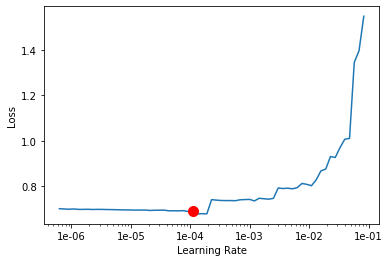

In [14]:
# find an appropriate lr
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [15]:
learn.model.roberta.train() # set roberta into train mode
learn.fit_one_cycle(1, max_lr=min_grad_lr) # train one cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.516510,0.400920,0.823755,00:40


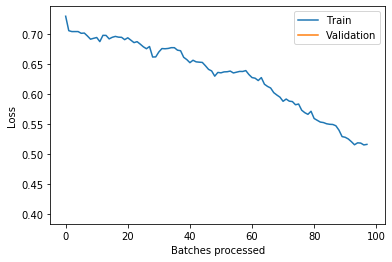

In [16]:
learn.recorder.plot_losses()

In [17]:
# train five epochs
learn.fit_one_cycle(5, max_lr=min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.435777,0.383246,0.865900,00:46
1,0.488802,0.421476,0.839080,00:46
2,0.434583,0.363648,0.862069,00:53
3,0.302941,0.249595,0.919540,00:41
4,0.236195,0.274029,0.911877,00:54


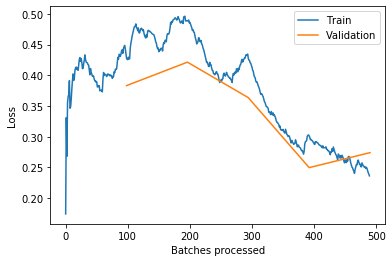

In [18]:
# We will also use learn.recorder.plot_losses() to track our loss function over the epochs.
learn.recorder.plot_losses()

In [19]:
# unfreeze layers
#learn.unfreeze()
#learn.fit_one_cycle(1, max_lr=1e-5)

In [20]:
# train using half precision
# learn = learn.to_fp16()

### 5. Make inference

In [21]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values
# For Valid
# preds, pred_values = get_preds_as_nparray(DatasetType.Valid)

In [22]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [23]:
# test_preds

In [24]:
# len(test_preds[0]), len(test_preds[1])

In [25]:
ebc = EvaluateBinaryClassification(gnd_truths = test['label'].to_list(), predictions = test_preds[1])
print(ebc.get_full_report())

EvaluateBinaryClassification Object Created

Total Samples	54356
Positive Samples	39
Negative Samples	54317
True Positive	25
True Negative	50593
False Positive	3724
False Negative	14
Accuracy	0.9312311428361174
Precision	0.006668444918644972
Recall	0.6410256410256411
F1 Measure	0.013199577613516367
Cohen Kappa Score	0.011796120528438703
Area Under Curve	0.7862325767585631

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     54317
           1       0.01      0.64      0.01        39

    accuracy                           0.93     54356
   macro avg       0.50      0.79      0.49     54356
weighted avg       1.00      0.93      0.96     54356



Source: https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c